# Importing Librarires

## LangSmith Configuration

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "Construction"


## Libraries

In [6]:

from langgraph.graph import START, END ,StateGraph
from typing import TypedDict,Optional,Dict,Any,Literal,List
from dotenv import load_dotenv
import os 
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import Field,BaseModel
from langchain_google_genai import ChatGoogleGenerativeAI

In [7]:
gemini_model =ChatGoogleGenerativeAI(model="gemini-2.5-flash",temperature=1 , api_key=os.getenv("gemini_api_key"))


# Main Class
- The StateGraph Class


In [8]:
class ConstructionInput(TypedDict):
    extraction_info: str # Extraaction from the description
    output:Optional[str] # the result of extraction
    company_info:Optional[str] # the company info from tavily
    company_name:str 
    all_company_content:str # all the content gathered by tavily
    summarized_content:str # after summarization all the tavily content
    links:Optional[list[str]]
    final_extraction_with_score:str



# First Node 

- `ExtractionInfoClass` : for the Description company

In [9]:
class ScopeCoverage(BaseModel):
    #included:list[Literal["HVC","Electrical","Interior"]]
    included:list[str]
    excluded:list[str]
    sub_contracted: list[str]

class CostDetails(BaseModel):
    target_budget_usd:str
    overrun_percentage:int
    hard_stop_usd:str


class TimelineDetails(BaseModel):
    target_completion_months:int
    acceptable_extension_weeks:int
    delay_penalties:str


    
class ExtractionInfo(BaseModel):
    Company_name: str = Field(description="Company name")
    cost: CostDetails = Field(description="Cost details")
    # Dict[key,value] --> i want keys in str format, and values in `Any` format
    timeline: TimelineDetails = Field(description="Project timeline")
    prior_similar_projects_count:int = Field(description="Number of prior similar projects")
    scope_coverage:ScopeCoverage = Field(description="The project coverage materials, choose only HVC, Electrical or Interior")
    legal_and_compliance:str =Field(description="Legal and Compliances that included in the project")


## First Node Function

In [10]:
def extract_construction_info(state: ConstructionInput):
    
    prompt = "\n".join([
        "You are an expert construction project manager and requirements analyst.",
        "Your task is to EXTRACT structured data from the input.",
        "",
        "STRICT RULES (MANDATORY):",
        "- You MUST return VALID JSON only.",
        "- Do NOT include explanations, summaries, or text outside JSON.",
        "- Every field must match the required type exactly.",
        "- If information is missing or unclear, return an empty object {} or null.",
        "",
        "DATA TYPE RULES:",
        "- cost MUST be a JSON object (dictionary), never a string.",
        "- timeline MUST be a JSON object (dictionary), never a string.",
        "- The keys inside cost and timeline may vary depending on the input.",
        "- Values inside cost and timeline may be numbers, strings, or nested objects.",
        "",
        "EXAMPLES:",
        "If the input says: '$1.2M target, $1.35M hard stop'",
        "Return:",
        '{ "cost": { "target": 1200000, "hard_stop": 1350000 } }',
        "",
        "If the input provides cost in free text and exact values are unclear:",
        '{ "cost": { "raw": "original text here" } }',
        "",
        "Your Responsibilities:",
        "1- Extract structured requirements",
        "2- Identify constraints and priorities",
        "3- Convert budget and timeline information into JSON objects",
        "4- in ScopeCoverage, summarize each sentence to be only either one of those [HVC,Interior,Electrical]"
        "",
        "INPUT:",
        f"{state['extraction_info']}",
        "",
        "OUTPUT JSON ONLY:"
    ])

    response = gemini_model.with_structured_output(ExtractionInfo).invoke(prompt)
    print("Gemini Response:", response)

#    return {"output": response}
    return {"output": response}



## Second Node
- `it searches for information about the companies wanted to take the bid`

# 2nd Node


In [12]:
class SearchCompanyInfo(BaseModel):
    company_name: str = Field(description="Company name")
    cost: str = Field(description="Cost details")
    timeline: str = Field(description="Project timeline")
    number_of_same_projects: int = Field(description="Number of prior similar projects")
    is_relevant: int = Field(description="How strong this company Is relevant to the Project, range from 0 to 10" ,ge=0 , le=10)



In [13]:
from langchain_tavily import TavilySearch
tavily = TavilySearch(max_results=5,search_depth="basic" , api_key=os.getenv("TAVILY_API_KEY"),include_raw_content="markdown",include_image_descriptions=False,include_images=False)

tavily_result = tavily.invoke("شركة طلعت مصطفى")

In [14]:
def search_company_info(state: ConstructionInput) -> SearchCompanyInfo:
    company_name = state["company_name"]
    search_result = tavily.invoke(company_name)
    # Process search_result to extract required fields
    search_contents = [item['content'] for item in search_result['results']]
    search_score = [item['score'] for item in search_result['results']]

    prompt = "\n".join([
        "You are an expert construction project analyst.",
        "Based on the following search results, extract the company's average cost, average timeline, number of similar projects, and relevance to the given project.",
        "DONT EVER ASSUME ANYTHING, IF YOU DONT FIND THE INFO , RETURN NULL or 0",
        "",
        "## SEARCH RESULTS:",
        f"{search_contents}",
        "## SEARCH SCORES For each result:",
        f"{search_score}",
        "",
        "OUTPUT FORMAT (JSON):",
        "{",
        '  "company_name": str,',
        '  "avg_cost": str,',
        '  "avg_timeline": str,',
        '  "number_of_same_projects": int,',
        '  "is_relevant": bool',
        "}"
    ])

    response = gemini_model.with_structured_output(SearchCompanyInfo).invoke(prompt)
    print("Gemini Company Info Response:", response)
    return {"company_info": response}



# 3rd Node

## Summarize all the content of 2nd Node

In [15]:
def search_company_info(state: ConstructionInput):
    company_name = state["company_name"]
    search_result = tavily.invoke(company_name)
    # Process search_result to extract required fields
    search_raw_contents = [item['raw_content'] for item in search_result['results']]
    search_url = [item["url"] for item in search_result["results"]]
    print(f"Links provided : \n\n{search_url}")
    
    return {"all_company_content": search_raw_contents , "links": search_url}




def summarized_company_content(state:ConstructionInput):
    all_content = state['all_company_content']
    prompt = "\n".join([
        "You are an expert construction project analyst.",
        "You have collected multiple pieces of information about a company.",
        "Your task: Summarize all the content in detail, without skipping any important information.",
        "Specifically, include:",
        "1. How many projects the company has completed related to the current project, with details if available.",
        "2. Any red flags in the company's history or performance or timeline alignment.",
        "3. Whether the company aligns with the protocols and requirements in the project details.",
        "4. Any negative reports, bad news, or reputational concerns.",
        "5. Any other observations that could impact the project decision.",
        "Write a concise but complete plain text summary, combining all information from the collected content.",
        "Be explicit and do not leave out anything important.",
        "### Input:",
        f"{all_content}",
        "### Output:"
    ])

    response = gemini_model.invoke((prompt))
    print(f"Summarized Content : {response.content}")
    print("--- Summary Node is Done Successfully ---")
    return {"summarized_content":response.content}

# Graph 4

- **`Structure & Evaluate the output against the bid company`**

In [16]:
class KeySignals(BaseModel):
    us_commercial_experience: bool = Field(description="Has US commercial experience")
    project_scale_alignment: str = Field(description="Alignment of project scale: Low/Medium/High")
    recent_negative_news: bool = Field(description="Any recent negative news or bad reputation")

class Confidence(BaseModel):
    overall_confidence:float = Field(description="Overall confidence in the entire extraction")
    explanation:str=Field(description="on what basis you put this confidence")

class ExternalCompanyInsights(BaseModel):
    company_name:str=Field(description="Company Name")
    sources: List[str] = Field(description="List of URLs or references")
    external_company_insights: KeySignals = Field(description="Structured insights per company")
    overall_confidence: Confidence = Field(description="Overall confidence in the entire extraction")


In [17]:
def summary_extractor_evaluator(state:ConstructionInput):


    prompt = "\n".join([
        "You are an expert construction project analyst.",
        "You are given:",
        "1) Project requirements and protocols",
        "2) External information about companies (history, completed projects, reputation, news, public signals)",
        "",
        "Your task is to evaluate how well each company aligns with the project requirements by comparing the two sources.",
        "",
        "Evaluation instructions:",
        "- Compare each company's past projects, construction scope, and technical experience against the project requirements.",
        "- Identify alignment, partial alignment, gaps, inconsistencies, or red flags.",
        "- Consider reputation signals such as negative news, disputes, failures, or regulatory issues if present.",
        "- Base all judgments strictly and only on the provided content.",
        "",
        "Confidence interpretation rules (VERY IMPORTANT):",
        "- You MUST compute an overall_confidence score between 0 and 1.",
        "- The confidence score MUST be justified using an explicit explanation field.",
        "- The confidence score should be based on the following factors combined:",
        "  1) Strength of prior experience: relevance and similarity of past projects to the current project.",
        "  2) Evidence quality: clarity, consistency, and credibility of the provided information and sources.",
        "  3) Reputation signals: presence or absence of negative news, disputes, failures, or red flags.",
        "  4) Alignment completeness: how fully the company aligns with the stated project protocols and scale.",
        "",
        "Scoring guidance (implicit, do not output these rules):",
        "- High confidence (close to 1): strong relevant experience, clear alignment, reputable track record, no major red flags.",
        "- Medium confidence (~0.4–0.7): partial alignment, limited evidence, mixed or unclear signals.",
        "- Low confidence (close to 0): weak or irrelevant experience, poor evidence quality, or significant negative signals.",
        "",
        "For each company, extract structured insights in JSON with the following fields:",
        "- company_name",
        "- sources: URLs or references used",
        "- external_company_insights:",
        "    - us_commercial_experience: true if evidence exists, otherwise false",
        "    - project_scale_alignment: 'Low', 'Medium', or 'High' based on comparison with project requirements",
        "    - recent_negative_news: true if any bad news, disputes, or reputational risks are present",
        "- overall_confidence:",
        "    - overall_confidence: float (0–1)",
        "    - explanation: a concise explanation describing EXACTLY why this confidence score was assigned, referencing experience, reputation, evidence strength, and alignment",
        "",
        "IMPORTANT RULES:",
        "- Output VALID JSON ONLY.",
        "- Do NOT invent information.",
        "- If evidence is missing or weak, reflect that directly in both the confidence score and its explanation.",
        "",
        "## Project Requirements and Protocols:",
        f"{state['extraction_info']}",
        "",
        "## External Company Information:",
        f"{state['summarized_content']}",
        "",
        "## Sources:",
        f"{state['links']}"
    ])


    response = gemini_model.with_structured_output(ExternalCompanyInsights).invoke(prompt)

    return {"final_extraction_with_score": response}


    


## Building the Graph

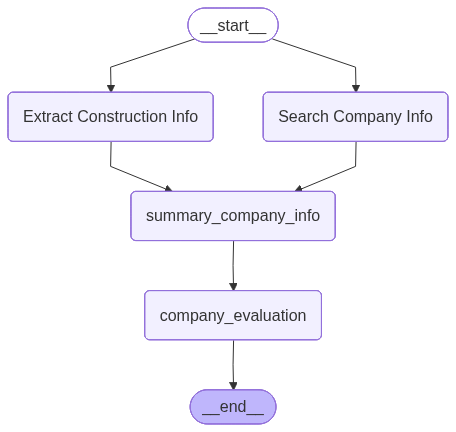

In [18]:
graph = StateGraph(ConstructionInput)
graph.add_node("Extract Construction Info",extract_construction_info)
graph.add_node("Search Company Info",search_company_info)
graph.add_node("summary_company_info" , summarized_company_content)
graph.add_node("company_evaluation" ,summary_extractor_evaluator)

graph.add_edge(START, "Extract Construction Info")
graph.add_edge(START, "Search Company Info")
graph.add_edge("Search Company Info" , "summary_company_info")
graph.add_edge("summary_company_info","company_evaluation")
graph.add_edge("Extract Construction Info","summary_company_info")
graph.add_edge("company_evaluation", END)
graph = graph.compile()
graph

## Example used for testing
- I copy paste the description from the task.txt

In [11]:
project_instructions ="""

commercial renovation 

Project ID: LA-CR-0426-MX
Location: Downtown Los Angeles
Building Type: Mixeduse commercial (offices, retail)
Building Age: 28 years (last renovation 2009)

1  Overview 

Mid size but operationally sensitive commercial renovation of an occupied mixed  use building in downtown Los Angeles  The building must remain partially operational throughout construction, with tenants present on floors 2 and 4 during weekdays 

The renovation scope includes core MEP upgrades, interior modernization, and selective structural reinforcement, with strong emphasis on safety, regulatory compliance, and schedule reliability 

While cost matters, delivery risk and operational disruption are higher  priority concerns 

2  Scope of Work
Mandatory Inclusions

Electrical rewiring (legacy copper , partial aluminum)

HVAC system upgrade (central , floor  level units)

Interior redesign (lobby, common areas, 3 office floors)

Conditional / Ambiguous Items

Fire suppression system upgrade (required if electrical scope triggers code review)

Seismic bracing (recommended, not explicitly mandated)

Smart building sensors (nice  to  have, budget dependent)

Note: Some historical blueprints are missing or outdated 

3  Constraints & Preferences (Conflicting by Design)
Budget

Target budget: $1 2M

Acceptable overrun: up to ,8% if risk reduction is demonstrable

Hard stop above $1 35M unless scope reduction justified

Timeline

Target completion: 6 months

Acceptable extension: ,2 weeks

Penalties apply for delays beyond that

Operational Constraints

No full  day power shutdowns on weekdays

Noise  intensive work restricted to weekends and nights

HVAC downtime must be staged floor  by  floor

4  Regulatory & Compliance Considerations

Must comply with California Title 24

City permits required; approval timelines historically unpredictable

Building has prior minor OSHA citation (resolved, but reputational sensitivity)

5  Contractor Requirements (Implicit , Explicit)
Explicit

Proven US commercial renovation experience

Ability to manage multi  phase, occupied  building projects

Strong safety record

Implicit / Soft Signals

Familiarity with LA city permitting processes

Local subcontractor network preferred

History of handling legacy electrical systems is a plus

6  Bid Evaluation Guidance (Non  Numeric, Subjective)

We are not simply selecting the cheapest or fastest bid 

Decision should consider:

Scope completeness vs hidden exclusions

Realism of timelines vs confidence levels

Risk introduced by subcontracting critical paths

Evidence of similar past projects

External reputation and delivery history

We are willing to accept:

Slightly higher cost

Slightly longer timelines

If and only if risk and disruption are demonstrably lower 

7  Known Risks & Ambiguities (Buried Signals)

One prior renovation experienced a 6  week delay due to permit revisions

Electrical infrastructure condition worse than documented

One tenant is planning a lease renewal contingent on minimal disruption

Insurance provider has flagged construction risk as “moderate  high”

"""

In [19]:
result = graph.invoke({"extraction_info": project_instructions, "company_name": "شركة طلعت مصطفى للمقاولات"})

Links provided : 

['https://ar.wikipedia.org/wiki/%D9%85%D8%AC%D9%85%D9%88%D8%B9%D8%A9_%D8%B7%D9%84%D8%B9%D8%AA_%D9%85%D8%B5%D8%B7%D9%81%D9%89', 'https://eg.linkedin.com/company/talaatmoustafagroup', 'https://talaatmoustafa.sa/ar', 'https://www.instagram.com/talaatmoustafagroup_abudhabi/?hl=en', 'https://talaatmoustafa.com/ar/home-page-ar/']
Gemini Response: Company_name='' cost=CostDetails(target_budget_usd='1200000', overrun_percentage=8, hard_stop_usd='1350000') timeline=TimelineDetails(target_completion_months=6, acceptable_extension_weeks=2, delay_penalties='Penalties apply for delays beyond acceptable extension') prior_similar_projects_count=1 scope_coverage=ScopeCoverage(included=['Electrical', 'HVC', 'Interior'], excluded=[], sub_contracted=[]) legal_and_compliance='Compliance with California Title 24, City permits required, prior minor OSHA citation (resolved), regulatory compliance.'
Summarized Content : Talaat Moustafa Group (TMG) is a prominent Egyptian holding company fou

{'extraction_info': '\n\ncommercial renovation \n\nProject ID: LA-CR-0426-MX\nLocation: Downtown Los Angeles\nBuilding Type: Mixeduse commercial (offices, retail)\nBuilding Age: 28 years (last renovation 2009)\n\n1  Overview \n\nMid size but operationally sensitive commercial renovation of an occupied mixed  use building in downtown Los Angeles  The building must remain partially operational throughout construction, with tenants present on floors 2 and 4 during weekdays \n\nThe renovation scope includes core MEP upgrades, interior modernization, and selective structural reinforcement, with strong emphasis on safety, regulatory compliance, and schedule reliability \n\nWhile cost matters, delivery risk and operational disruption are higher  priority concerns \n\n2  Scope of Work\nMandatory Inclusions\n\nElectrical rewiring (legacy copper , partial aluminum)\n\nHVAC system upgrade (central , floor  level units)\n\nInterior redesign (lobby, common areas, 3 office floors)\n\nConditional / A
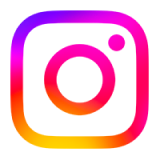
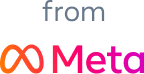

In [20]:
result

In [22]:
print(result["final_extraction_with_score"].model_dump_json(indent=4))

{
    "company_name": "Talaat Moustafa Group (TMG)",
    "sources": [
        "https://ar.wikipedia.org/wiki/%D9%85%D8%AC%D9%85%D9%88%D8%B9%D8%B9%D8%A9_%D8%B7%D9%84%D8%B9%D8%AA_%D9%85%D8%B5%D8%B7%D9%81%D9%89",
        "https://eg.linkedin.com/company/talaatmoustafagroup",
        "https://talaatmoustafa.sa/ar",
        "https://www.instagram.com/talaatmoustafagroup_abudhabi/?hl=en",
        "https://talaatmoustafa.com/ar/home-page-ar/"
    ],
    "external_company_insights": {
        "us_commercial_experience": false,
        "project_scale_alignment": "Low",
        "recent_negative_news": true
    },
    "overall_confidence": {
        "overall_confidence": 0.1,
        "explanation": "Overall confidence is low due to the complete lack of US commercial renovation experience, a significant mismatch in project scale (TMG specializes in mega-developments, not mid-size renovations of occupied buildings), and a major historical reputational concern regarding the CEO's murder conviction. 